#  MACHINE LEARNING: Portugal Wine under Two Class approach for Red and White classification with Logistic Regression using R and K fold cross-validation
# Module 3: Solving project with dataset dffful


By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 30, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]
<hr>

# I Introduction

We consider the original dataset without the variables "density" and "free.sulfor.dioxide".

<u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>.


We consider outliers those points that have any predictor variable value to be outside of the limits constructed by boxplots. The following rule is applied:

* A predictor value is considered to be an upper outlier only if it is greater than <b>Threshold = Q3 + 1.5IQR</b>

Application of this rule oes not reduces the original datasize becouse it does not eliminate any register.  So, <i>dfffull</i></b></u> data size is the same as the original "df" 6497).

# II Loading and the Data

In [117]:
# first remove ALL objects and close all possible connections
closeAllConnections()
rm(list = ls(all = TRUE)) # Does remove all inclusive hidden

# see your memory size
memory.size() 

In [1]:
# install packages and load libraries
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = c("Depends", "Suggests"))
    sapply(pkg, require, character.only = TRUE)
}
# usage
packages <- c("plyr", "dplyr", "car","caret")
ipak(packages)


Loading required package: plyr
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: car
Warning message:
"package 'car' was built under R version 3.4.2"
Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


plyr dplyr   car caret 
 TRUE  TRUE  TRUE  TRUE

In [4]:
# define path location of datasets
wine1.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine2.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# read datasets
wine1 <- read.csv(wine1.url, header=TRUE, sep=';')
wine2 <- read.csv(wine2.url, header=TRUE, sep=';')

# create dataset base
paso <- rbind(cbind(wine1, Class='white'), cbind(wine2, Class='red'))
#paso$quality<- ifelse(paso$quality>=6, "Good", ifelse(paso$quality<6, "Bad", NA))

df= subset(paso, select=c('fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides' ,'total.sulfur.dioxide','pH', 'sulphates', 'alcohol', 'quality', 'Class'))
attach(df)
head(df)
rm("paso", "wine1", "wine2")

The following objects are masked from df (pos = 3):

    alcohol, chlorides, citric.acid, Class, fixed.acidity, pH, quality,
    residual.sugar, sulphates, total.sulfur.dioxide, volatile.acidity



fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,6,white
6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,6,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,white


In [5]:
# verify response variable "quality" as factor
df$Class <- as.factor(df$Class)

In [6]:
# get some information about the dataset
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [7]:
#summarize full dataset by columns 
propmiss <- function(dataframe) {
	m <- sapply(dataframe, function(x) {
		data.frame(
			n=length(!is.na(x)), 
			nmiss=sum(is.na(x)), 
			propmiss=sum(is.na(x))/length(x),
			P25=round(quantile(x, 0.25, na.rm=TRUE),2),
			P75=round(quantile(x, 0.75, na.rm=TRUE),2),            
			IQR=round(IQR(x, na.rm=TRUE),2),
			Threshold= round(quantile(x, 0.75, na.rm=TRUE),2) + 1.5*round(IQR(x, na.rm=TRUE),2),            
			Minimum=round(min(x, na.rm=TRUE),2),
			Median=round(median(x, na.rm=TRUE),2),            
			Maximum=round(max(x, na.rm=TRUE),2),
			Range=round(max(x, na.rm=TRUE)-min(x, na.rm=TRUE),2),
			Mean=round(mean(x, na.rm=TRUE),2),
			StDev=round(sd(x, na.rm=TRUE),2)
		)
	})
	d <- data.frame(t(m))
	d <- sapply(d, unlist)
	d <- as.data.frame(d)
	d$variable <- row.names(d)
	row.names(d) <- NULL
	d <- cbind(d[ncol(d)],d[-ncol(d)])
	return(d[order(d$propmiss), ])
}

In [8]:
# summarize original df dataset
(summary1=propmiss(df[,-c(10:11)])[,-(3:4)])

variable,n,P25,P75,IQR,Threshold,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,9.650,3.80,7.00,15.90,12.10,7.22,1.30
volatile.acidity,6497,0.23,0.40,0.17,0.655,0.08,0.29,1.58,1.50,0.34,0.16
citric.acid,6497,0.25,0.39,0.14,0.600,0.00,0.31,1.66,1.66,0.32,0.15
residual.sugar,6497,1.80,8.10,6.30,17.550,0.60,3.00,65.80,65.20,5.44,4.76
chlorides,6497,0.04,0.06,0.03,0.105,0.01,0.05,0.61,0.60,0.06,0.04
total.sulfur.dioxide,6497,77.00,156.00,79.00,274.500,6.00,118.00,440.00,434.00,115.74,56.52
pH,6497,3.11,3.32,0.21,3.635,2.72,3.21,4.01,1.29,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.855,0.22,0.51,2.00,1.78,0.53,0.15
alcohol,6497,9.50,11.30,1.80,14.000,8.00,10.30,14.90,6.90,10.49,1.19


In [9]:
# r code to replace outliers by the threshold of each variable
library(mlr)

Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train



In [11]:
dfffull <- capLargeValues(df, target = "Class",cols = c("fixed.acidity"),threshold = summary1[1,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("volatile.acidity"),threshold = summary1[2,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("citric.acid"),threshold = summary1[3,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("residual.sugar"),threshold = summary1[4,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("chlorides"),threshold = summary1[5,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("total.sulfur.dioxide"),threshold = summary1[6,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("pH"),threshold = summary1[7,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("sulphates"),threshold = summary1[8,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("alcohol"),threshold = summary1[9,6])
unloadNamespace("mlr")

In [12]:
# get some information about the dataset
str(dfffull)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [13]:
# remove and dettach df dataset
rm("df")
detach("df")

In [14]:
# rename dff dataset as df dataset to use the already created R scripts
df <- dfffull

# remove dff dataset
rm("dfffull")

In [15]:
head(df)
str(df)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white
6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


# III Getting train and test datasets

In [18]:
#stratified sampling to get the train and test dataset
set.seed(7) # Set Seed so that same sample can be reproduced in future also
# considering response variable as strata
data_part <- createDataPartition(y = df$Class ,  p = 0.70, list = F)
testing <- df[-data_part,] # 30% data goes here
training <- df[data_part,] # 70% here

In [19]:
#taking a look of the train and test dataset by columns 
head(training)
head(testing)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
2,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,white
3,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white
7,6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,6,white
8,7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white
9,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,white
10,8.1,0.22,0.43,1.50,0.044,129,3.22,0.45,11.0,6,white


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
1,7.0,0.270,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white
4,7.2,0.230,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
5,7.2,0.230,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
6,8.1,0.280,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white
18,6.2,0.655,0.48,1.20,0.029,75,3.33,0.39,12.8,8,white
20,6.5,0.310,0.14,7.50,0.044,133,3.22,0.50,9.5,5,white


In [20]:
# get some information about training dataset
str(training[,1:11])

'data.frame':	4549 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 8.1 6.2 7 6.3 8.1 8.1 8.6 7.9 6.6 ...
 $ volatile.acidity    : num  0.3 0.28 0.32 0.27 0.3 0.22 0.27 0.23 0.18 0.16 ...
 $ citric.acid         : num  0.34 0.4 0.16 0.36 0.34 0.43 0.41 0.4 0.37 0.4 ...
 $ residual.sugar      : num  1.6 6.9 7 17.5 1.6 ...
 $ chlorides           : num  0.049 0.05 0.045 0.045 0.049 0.044 0.033 0.035 0.04 0.044 ...
 $ total.sulfur.dioxide: num  132 97 136 170 132 129 63 109 75 143 ...
 $ pH                  : num  3.3 3.26 3.18 3 3.3 3.22 2.99 3.14 3.18 3.54 ...
 $ sulphates           : num  0.49 0.44 0.47 0.45 0.49 0.45 0.56 0.53 0.63 0.52 ...
 $ alcohol             : num  9.5 10.1 9.6 8.8 9.5 11 12 9.7 10.8 12.4 ...
 $ quality             : int  6 6 6 6 6 6 5 5 5 7 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [21]:
# get some information about testing dataset
str(testing[,1:11])

'data.frame':	1948 obs. of  11 variables:
 $ fixed.acidity       : num  7 7.2 7.2 8.1 6.2 6.5 6.8 6.6 7.2 6.2 ...
 $ volatile.acidity    : num  0.27 0.23 0.23 0.28 0.655 0.31 0.26 0.27 0.32 0.12 ...
 $ citric.acid         : num  0.36 0.32 0.32 0.4 0.48 0.14 0.42 0.41 0.36 0.34 ...
 $ residual.sugar      : num  17.5 8.5 8.5 6.9 1.2 ...
 $ chlorides           : num  0.045 0.058 0.058 0.05 0.029 0.044 0.049 0.052 0.033 0.045 ...
 $ total.sulfur.dioxide: num  170 186 186 97 75 133 122 142 114 117 ...
 $ pH                  : num  3 3.19 3.19 3.26 3.33 3.22 3.47 3.42 3.1 3.42 ...
 $ sulphates           : num  0.45 0.4 0.4 0.44 0.39 0.5 0.48 0.47 0.71 0.51 ...
 $ alcohol             : num  8.8 9.9 9.9 10.1 12.8 9.5 10.5 10 12.3 9 ...
 $ quality             : int  6 6 6 6 8 5 8 6 7 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [22]:
# summarize training dataset
(summary=propmiss(training[,-c(10:11)])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,4549,6.40,7.60,1.20,4.20,7.00,9.65,5.45,7.13,1.05
volatile.acidity,4549,0.23,0.41,0.18,0.08,0.30,0.66,0.58,0.33,0.14
citric.acid,4549,0.24,0.39,0.15,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,4549,1.80,8.10,6.30,0.60,2.90,17.55,16.95,5.39,4.61
chlorides,4549,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,4549,78.00,156.00,78.00,6.00,119.00,274.50,268.50,116.08,56.17
pH,4549,3.11,3.32,0.21,2.72,3.20,3.63,0.91,3.22,0.16
sulphates,4549,0.43,0.60,0.17,0.22,0.51,0.86,0.64,0.53,0.13
alcohol,4549,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.50,1.19


In [23]:
# summarize testing dataset
(summary=propmiss(testing[,-c(10:11)])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,1948,6.40,7.80,1.40,3.80,7.00,9.65,5.85,7.18,1.11
volatile.acidity,1948,0.23,0.40,0.17,0.08,0.29,0.66,0.57,0.33,0.14
citric.acid,1948,0.25,0.40,0.15,0.00,0.31,0.60,0.60,0.32,0.14
residual.sugar,1948,1.80,8.10,6.30,0.60,3.20,17.55,16.95,5.45,4.62
chlorides,1948,0.04,0.06,0.03,0.01,0.05,0.10,0.09,0.05,0.02
total.sulfur.dioxide,1948,75.75,155.00,79.25,6.00,117.00,274.50,268.50,114.72,56.46
pH,1948,3.10,3.32,0.22,2.79,3.21,3.63,0.84,3.22,0.16
sulphates,1948,0.43,0.60,0.17,0.25,0.50,0.86,0.60,0.53,0.13
alcohol,1948,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.47,1.20


# IV Logistic Regression
 
In this project I have considered Logistic Regression algorithm. I use "set.seed(7)" so that same sample can be reproduced in the future and also it ensures the results are directly comparable.

## 41 Building Machine Learning Model

### 411 Find model equation 

In [24]:
## modelo completo
set.seed(7)
model1<- glm(Class ~ ., data=training, family="binomial")
summary(model1)


Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5042  -0.0264  -0.0068  -0.0002   4.4378  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -57.127527   6.101197  -9.363  < 2e-16 ***
fixed.acidity          1.424435   0.208088   6.845 7.63e-12 ***
volatile.acidity      11.967769   1.429436   8.372  < 2e-16 ***
citric.acid           -2.139933   1.439344  -1.487   0.1371    
residual.sugar        -0.110185   0.065557  -1.681   0.0928 .  
chlorides            100.831215  10.112105   9.971  < 2e-16 ***
total.sulfur.dioxide  -0.056372   0.005037 -11.191  < 2e-16 ***
pH                    10.698591   1.344215   7.959 1.73e-15 ***
sulphates              9.577132   1.551751   6.172 6.75e-10 ***
alcohol               -0.022336   0.190016  -0.118   0.9064    
quality                0.162712   0.223943   0.727   0.4675    
---
Signif. codes:  0 '***' 0.001

In [25]:
# VIF variable inflation factor for each variable in the model
vif(model1)

fixed.acidity     volatile.acidity          citric.acid 
            1.964927             1.705881             1.687685 
      residual.sugar            chlorides total.sulfur.dioxide 
            1.157399             1.908283             1.605459 
                  pH            sulphates              alcohol 
            1.922731             1.333963             2.239832 
             quality 
            1.624017

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 7 for all variables ==> variables are ok and should be kept on the model. 

In [26]:
# best model Stepwise backward-AIC
model2<- step(glm(Class ~ ., family = binomial(link = "logit"), data=training), trace= F, direction="backward")
summary(model2)


Call:
glm(formula = Class ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + total.sulfur.dioxide + pH + 
    sulphates, family = binomial(link = "logit"), data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5881  -0.0263  -0.0067  -0.0002   4.4302  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -56.28109    5.46320 -10.302  < 2e-16 ***
fixed.acidity          1.41841    0.19337   7.335 2.21e-13 ***
volatile.acidity      11.63829    1.31842   8.827  < 2e-16 ***
citric.acid           -2.10947    1.40586  -1.500   0.1335    
residual.sugar        -0.10932    0.06536  -1.673   0.0944 .  
chlorides            100.14454    9.31258  10.754  < 2e-16 ***
total.sulfur.dioxide  -0.05652    0.00490 -11.534  < 2e-16 ***
pH                    10.67824    1.33877   7.976 1.51e-15 ***
sulphates              9.76820    1.45445   6.716 1.87e-11 ***
---
Signif. codes:  0 '***' 0.001

In [27]:
# VIF variable inflation factor for each variable in the model
vif(model2)

fixed.acidity     volatile.acidity          citric.acid 
            1.705381             1.459111             1.628497 
      residual.sugar            chlorides total.sulfur.dioxide 
            1.158397             1.608105             1.553743 
                  pH            sulphates 
            1.904484             1.175590

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 7 for all variables ==> variables are ok and should be kept on the model. 

In [28]:
## best model Stepwise backward-BIC
model3<- step(glm(Class ~ ., family = binomial(link = "logit"), data=training), trace= F, direction="backward", k=log(nrow(training)))
summary(model3)


Call:
glm(formula = Class ~ fixed.acidity + volatile.acidity + chlorides + 
    total.sulfur.dioxide + pH + sulphates, family = binomial(link = "logit"), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5680  -0.0271  -0.0075  -0.0003   4.5555  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -58.37000    5.43510 -10.739  < 2e-16 ***
fixed.acidity          1.35167    0.18084   7.474 7.76e-14 ***
volatile.acidity      12.44825    1.20376  10.341  < 2e-16 ***
chlorides             99.35596    8.95723  11.092  < 2e-16 ***
total.sulfur.dioxide  -0.05933    0.00465 -12.759  < 2e-16 ***
pH                    11.14532    1.32378   8.419  < 2e-16 ***
sulphates              9.83591    1.42198   6.917 4.61e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5077.87  on 4548  degrees of freedom
Residual

In [29]:
# VIF variable inflation factor for each variable in the model
vif(model3)

fixed.acidity     volatile.acidity            chlorides 
            1.524582             1.208338             1.577209 
total.sulfur.dioxide                   pH            sulphates 
            1.446111             1.915379             1.176101

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 4 for all variables ==> variables are ok and should be kept on the model. 

As we can see, Model2 (backward-AIC) has achieved a lower AIC value (model2-AIC= 303.03) being the best model according to the Stepwise method. Also, we can compare the models using the ANOVA and lmtest test. Let's say our null hypothesis is that second model is better than the first model. p < 0.05 would reject our hypothesis and in case p > 0.05, we'll fail to reject the null hypothesis.

In [30]:
#compare the models by using anova-chisq
anova(model1,model2,test = "Chisq")
anova(model1,model3,test = "Chisq")
anova(model2,model3,test = "Chisq")


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
4538,284.4634,NA,NA,NA
4540,285.0307,-2,-0.5672995,0.7530304


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
4538,284.4634,NA,NA,NA
4542,290.5541,-4,-6.090609,0.1924829


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
4540,285.0307,NA,NA,NA
4542,290.5541,-2,-5.52331,0.06318711


In [31]:
#compare the models by using lrtest-chisq
library(lmtest)
lrtest(model1, model2)
lrtest(model1, model3)
lrtest(model2,model3)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



#Df,LogLik,Df,Chisq,Pr(>Chisq)
11,-142.2317,NA,NA,NA
9,-142.5154,-2,0.5672995,0.7530304


#Df,LogLik,Df,Chisq,Pr(>Chisq)
11,-142.2317,NA,NA,NA
7,-145.2770,-4,6.090609,0.1924829


#Df,LogLik,Df,Chisq,Pr(>Chisq)
9,-142.5154,NA,NA,NA
7,-145.2770,-2,5.52331,0.06318711


Even though the Anova and lmtest procedures state that the third model is better than the second one, the p-value (0.06318711) in near the limit of the bound.  Besides, model 2 has smaller AIC  than model 3 (303.03; 304.55).  So, we will keep model2 and model 3 and we will evaluate both its performances as a supervised machine learning model. Then we will decide between them based on its ROC metric result.   

### 412 Building the model 

In [32]:
## Control Resampling Technique: 10-fold CV
fiveStats = function(...) c (twoClassSummary(...), defaultSummary(...))
cvCtrl <- trainControl(method = "cv", number=10,  summaryFunction = fiveStats, classProbs = TRUE, savePredictions=T)

In [33]:
## Construction Predictive Model2 and Model3
set.seed(7)
formula2 <- as.formula("Class ~ fixed.acidity + volatile.acidity + citric.acid + residual.sugar + chlorides + total.sulfur.dioxide + pH + sulphates")
formula3 <- as.formula("Class ~ fixed.acidity + volatile.acidity + chlorides + total.sulfur.dioxide + pH + sulphates")
lrmodel2 <- train(formula2, data=training, method="glm",   family=binomial, preProc = c("center", "scale"), tuneLength = 5, trControl = cvCtrl)
lrmodel3 <- train(formula3, data=training, method="glm",   family=binomial, preProc = c("center", "scale"), tuneLength = 5, trControl = cvCtrl)



In [34]:
## Getting summary of fitted model2
summary(lrmodel2)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5881  -0.0263  -0.0067  -0.0002   4.4302  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.2522     0.3720 -14.120  < 2e-16 ***
fixed.acidity          1.4874     0.2028   7.335 2.21e-13 ***
volatile.acidity       1.6829     0.1906   8.827  < 2e-16 ***
citric.acid           -0.2834     0.1889  -1.500   0.1335    
residual.sugar        -0.5039     0.3013  -1.673   0.0944 .  
chlorides              2.1224     0.1974  10.754  < 2e-16 ***
total.sulfur.dioxide  -3.1747     0.2752 -11.534  < 2e-16 ***
pH                     1.6897     0.2118   7.976 1.51e-15 ***
sulphates              1.2680     0.1888   6.716 1.87e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5077.87  on 4548  degrees of freedom
Residual deviance:  285.03  on 4540  degrees of freedom
A

In [35]:
## Getting summary of fitted model3
summary(lrmodel3)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5680  -0.0271  -0.0075  -0.0003   4.5555  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.1251     0.3483 -14.716  < 2e-16 ***
fixed.acidity          1.4174     0.1896   7.474 7.76e-14 ***
volatile.acidity       1.8000     0.1741  10.341  < 2e-16 ***
chlorides              2.1057     0.1898  11.092  < 2e-16 ***
total.sulfur.dioxide  -3.3323     0.2612 -12.759  < 2e-16 ***
pH                     1.7636     0.2095   8.419  < 2e-16 ***
sulphates              1.2768     0.1846   6.917 4.61e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5077.87  on 4548  degrees of freedom
Residual deviance:  290.55  on 4542  degrees of freedom
AIC: 304.55

Number of Fisher Scoring iterations: 9


In [36]:
## train results model2
lrmodel2

Generalized Linear Model 

4549 samples
   8 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4094, 4094, 4094, 4094, ... 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa    
  0.9975998  0.9941674  0.9821429  0.9912073  0.9763027


In [37]:
## train results model3
lrmodel3

Generalized Linear Model 

4549 samples
   6 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (6), scaled (6) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4094, 4094, 4095, 4094, ... 
Resampling results:

  ROC        Sens       Spec     Accuracy   Kappa    
  0.9978056  0.9950437  0.98125  0.9916484  0.9774556


Model 3 has better ROC metric than model 2 (0.9978056;  0.9975998).  In fact, it has better Sens, Accuracy and Kappa metrics too. So we decide to keep model 3 as the better model option.

In [39]:
## Test Set Results model3
lrPred3 <- predict(lrmodel3,testing, type="raw")
confusionMatrix(lrPred3, testing$Class, positive = "white")

Confusion Matrix and Statistics

          Reference
Prediction white  red
     white  1462    8
     red       7  471
                                          
               Accuracy : 0.9923          
                 95% CI : (0.9873, 0.9957)
    No Information Rate : 0.7541          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9792          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9952          
            Specificity : 0.9833          
         Pos Pred Value : 0.9946          
         Neg Pred Value : 0.9854          
             Prevalence : 0.7541          
         Detection Rate : 0.7505          
   Detection Prevalence : 0.7546          
      Balanced Accuracy : 0.9893          
                                          
       'Positive' Class : white           
                                          

In [40]:
## Predicting Class Probabilities model 3
lrProbs3 <- predict(lrmodel3, testing, type = "prob")
head(lrProbs3)

,white,red
1,0.9999983,1.675077e-06
4,0.9999905,9.549344e-06
5,0.9999905,9.549344e-06
6,0.9830647,1.693535e-02
18,0.9208732,7.912683e-02
20,0.9997836,2.164233e-04


In [41]:
# variable importance model2
lr.imp3 = varImp (lrmodel3 , scale = F )
lr.imp3

glm variable importance

                     Overall
total.sulfur.dioxide  12.759
chlorides             11.092
volatile.acidity      10.341
pH                     8.419
fixed.acidity          7.474
sulphates              6.917

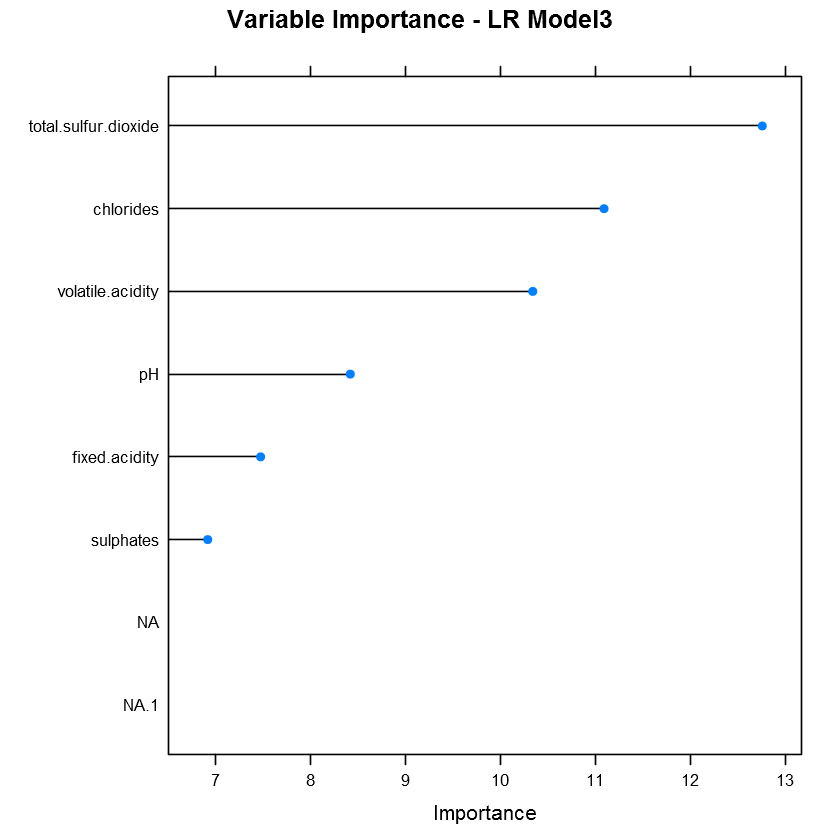

In [42]:
## Graphic variable importance model2
# dev.new()
plot(lr.imp3, top=8, main="Variable Importance - LR Model3")

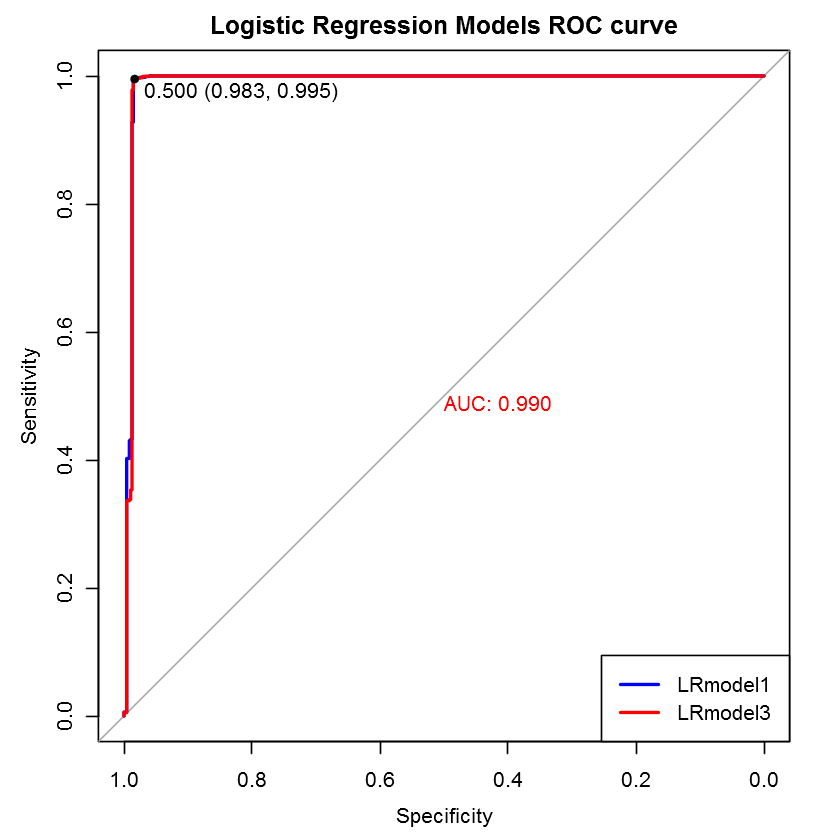

In [44]:
## Creating the ROC Curve
library(pROC)
formula1 <- as.formula("Class ~ .") 
lrmodel1 <- train(formula1, data=training, method="glm",   family=binomial, preProc = c("center", "scale"), tuneLength = 5, trControl = cvCtrl)
lrProbs <- predict(lrmodel1, testing, type = "prob")

## Creating the ROC Curve
library(pROC)
lrROC <- roc(predictor = lrProbs$white, response = testing$Class, levels = rev(levels(testing$Class)))
lrROC3 <- roc(predictor = lrProbs3$white, response = testing$Class, levels = rev(levels(testing$Class)))

plot(lrROC, type = "S", main="Logistic Regression Models ROC curve",  col = "blue")
plot(lrROC3, add = TRUE, print.thres = .5, col = "red", print.auc=TRUE)
#plot(knnROC, add = TRUE, col = "yellow")
#plot(rfROC, add = TRUE, print.thres = .5, col = "blue", print.auc=TRUE)
legend("bottomright", legend = c("LRmodel1","LRmodel3"), col = c("blue","red"),lwd = 2)


## V Making predictions
 
After doing all the building stuff, we want to get the predictions from model3 on our training dataset.

In [46]:
# print predictions probabilities by row model3
head(as.data.frame(lrProbs3),5)

,white,red
1,0.9999983,1.675077e-06
4,0.9999905,9.549344e-06
5,0.9999905,9.549344e-06
6,0.9830647,1.693535e-02
18,0.9208732,7.912683e-02


In [47]:
# print validation dataset and predictions by row model3
head((val<-as.data.frame(c(testing,as.data.frame(lrPred3)))),10)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class,lrPred3
7.0,0.270,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white,white
7.2,0.230,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white,white
7.2,0.230,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white,white
8.1,0.280,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white,white
6.2,0.655,0.48,1.20,0.029,75,3.33,0.39,12.8,8,white,white
6.5,0.310,0.14,7.50,0.044,133,3.22,0.50,9.5,5,white,white
6.8,0.260,0.42,1.70,0.049,122,3.47,0.48,10.5,8,white,white
6.6,0.270,0.41,1.30,0.052,142,3.42,0.47,10.0,6,white,white
7.2,0.320,0.36,2.00,0.033,114,3.10,0.71,12.3,7,white,white
6.2,0.120,0.34,1.50,0.045,117,3.42,0.51,9.0,6,white,white


Now if you want to get the predictions from a new test data, you can see the item 7.4 of my project [MACHINE LEARNING: A comparison of supervised learning algorithms applied to the classification problem with caret R-project library](http://nbviewer.jupyter.org/github/arqmain/Machine_Learning/blob/master/R_MLearning/MLearning_Classification_Comparison_R_Caret/MLearning_Classification_Comparison_R_Caret.ipynb). 

## VI Conclusion

This module of the project develops Logistic Regression algorithm of machine learning to classify the Class of wine "white" or "red" according to the 11 variables that characterize the wine subject to classification.

The database -dfffull- does not consider two variables that appear in the original base. They could generate a problem of multicollinearity in the process of classification. So,  we got rid of them in dfffull. At the same time, <u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>. The application of this rule does not reduce the original data size because it does not eliminate any register. So, dfffull data size is the same as the original "df" (6497).

The lrmodel3 achieves a good classification metric, reaching ROC measurement of 99.78%. That is, the variables of the "df" database allow discriminating in a good way the quality of wine that they represent.

The model was developed selecting the variables included by using the stepwise backward elimination method based on AIC selection criterion. Anyway, this is modeling so, we can improve more or not the model by filtering other variables, using another variable selection method or doing both things at the same time.

<hr>
By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 30, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]